In [45]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [1]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='gee-481701')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [3]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

Mount Everest elevation (m): 8729


In [4]:
lat, lon = 42.357214057576215, -71.05126036022881

point = ee.Geometry.Point(lon, lat)

In [6]:
landsat_collections = {
    "L4": ("LANDSAT/LT04/C02/T1_L2", "ST_B6"),
    "L5": ("LANDSAT/LT05/C02/T1_L2", "ST_B6"),
    "L7": ("LANDSAT/LE07/C02/T1_L2", "ST_B6"),
    "L8": ("LANDSAT/LC08/C02/T1_L2", "ST_B10"),
    "L9": ("LANDSAT/LC09/C02/T1_L2", "ST_B10"),
}

In [27]:
def mask_qa_pixel(img):
    qa = img.select("QA_PIXEL")

    # Bits to mask
    cloud        = qa.bitwiseAnd(1 << 3).neq(0)
    cloud_shadow = qa.bitwiseAnd(1 << 4).neq(0)
    snow         = qa.bitwiseAnd(1 << 5).neq(0)
    cirrus       = qa.bitwiseAnd(1 << 2).neq(0)

    mask = (
        cloud
        .Or(cloud_shadow)
        .Or(snow)
        .Or(cirrus)
        .Not()
    )

    return img.updateMask(mask)


In [7]:
def scale_lst(img, band):
    lst = (
        img.select(band)
        .multiply(0.00341802)
        .add(149.0)
        .rename("LST_K")
    )
    return img.addBands(lst, overwrite=True)


In [28]:
def extract_lst(collection_id, band, point):
    col = (
        ee.ImageCollection(collection_id)
        .filterBounds(point)
        .map(mask_qa_pixel)           # ← QA FILTER HERE
        .map(lambda img: scale_lst(img, band))
    )

    def sample(img):
        sample = img.select("LST_K").sample(
            region=point,
            scale=30,
            geometries=False
        ).first()

        return ee.Feature(None, {
            "time": ee.Date(img.get("system:time_start")).format("YYYY-MM-dd HH:mm:ss"),
            "lst_k": ee.Algorithms.If(sample, sample.get("LST_K"), None),
            "mission": collection_id
        })

    return col.map(sample)


In [29]:
features = []

for mission, (collection_id, band) in landsat_collections.items():
    fc = extract_lst(collection_id, band, point)
    features.append(fc)

merged = ee.FeatureCollection(features).flatten()


In [30]:
import numpy as np

In [31]:
results['features'][100]['properties']

{'lst_k': 286.20274082000003,
 'mission': 'LANDSAT/LT05/C02/T1_L2',
 'time': '1990-10-10 14:46:43'}

In [32]:
results = merged.getInfo()

data = []

for f in results["features"]:
    props = f["properties"]
    if "lst_k" in props:
        data.append((
            props["time"],
            props["lst_k"],
            props["mission"]
        ))

# Convert to NumPy array if desired
data_array = np.array(data, dtype=object)


In [33]:
print(data_array[:5])

[['1983-02-01 14:56:22' 278.1840659 'LANDSAT/LT04/C02/T1_L2']
 ['1997-08-26 14:58:33' 299.8372226 'LANDSAT/LT05/C02/T1_L2']
 ['2000-09-19 15:04:56' 297.76590248 'LANDSAT/LT05/C02/T1_L2']
 ['2000-10-21 15:05:21' 291.75018728 'LANDSAT/LT05/C02/T1_L2']
 ['2001-02-26 15:06:50' 278.96679248 'LANDSAT/LT05/C02/T1_L2']]


In [34]:
data_celsius = [
    (t, lst_k - 273.15, mission)
    for t, lst_k, mission in data
]


In [41]:
times, lsts = [], []

In [43]:
for data in data_celsius:
    times.append(data[0])
    lsts.append(data[1])

In [95]:
import pandas as pd
from scipy.optimize import curve_fit

In [96]:
def get_time_lsts(lon, lat):
    point = ee.Geometry.Point(lon, lat)

    features = []

    for mission, (collection_id, band) in landsat_collections.items():
        fc = extract_lst(collection_id, band, point)
        features.append(fc)

    merged = ee.FeatureCollection(features).flatten()

    results = merged.getInfo()

    data = []

    for f in results["features"]:
        props = f["properties"]
        if "lst_k" in props:
            data.append((
                props["time"],
                props["lst_k"],
                props["mission"]
            ))

    # Convert to NumPy array if desired
    data_array = np.array(data, dtype=object)

    data_celsius = [
        (t, lst_k - 273.15, mission)
        for t, lst_k, mission in data
    ]

    times, lsts = [], []

    for data in data_celsius:
        times.append(data[0])
        lsts.append(data[1])

    return times, lsts

In [97]:
lat2, lon2 = 42.357160021770675, -71.05292886447957
lat3, lon3 = 42.35800033248067, -71.05545341892267

In [98]:
times2, lsts2 = get_time_lsts(lon2, lat2)


In [99]:
times3, lsts3 = get_time_lsts(lon3, lat3)

In [112]:
dates = pd.to_datetime(times)
y = np.array(lsts)
t = (dates - dates.min()).total_seconds().values / (365.25 * 24 * 3600)

In [113]:
dates2 = pd.to_datetime(times2)
y2 = np.array(lsts2)
t2 = (dates2 - dates2.min()).total_seconds().values / (365.25 * 24 * 3600)

In [114]:
dates3 = pd.to_datetime(times3)
y3 = np.array(lsts3)
t3 = (dates3 - dates3.min()).total_seconds().values / (365.25 * 24 * 3600)

In [107]:
from scipy.optimize import curve_fit

In [108]:
import matplotlib.pyplot as plt


In [101]:
def sine_model(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C


In [102]:
def sine_trend(t, A, phi, B, C):
    return A * np.sin(2 * np.pi * t + phi) + B * t + C


In [109]:
def fit_graph_print(dates, y, t):
    A0 = (y.max() - y.min()) / 2
    phi0 = 0.0
    B0 = 0.00      # ~0.02 K/year (~2 K/century)
    C0 = y.mean()

    p0 = [A0, phi0, B0, C0]

    params, covariance = curve_fit(
        sine_trend,
        t,
        y,
        p0=p0
    )

    A, phi, B, C = params

    t_fit = np.linspace(t.min(), t.max(), 1000)
    y_fit = sine_trend(t_fit, A, phi, B, C)

    trend_only = B * t_fit + C
    seasonal_only = A * np.sin(2 * np.pi * t_fit + phi)

    plt.figure(figsize=(11, 5))
    plt.scatter(dates, y, s=10, alpha=0.6, label="Observed LST")
    plt.plot(
        dates.min() + pd.to_timedelta(t_fit * 365.25, unit="D"),
        y_fit,
        color="red",
        label="Sine + trend fit"
    )
    plt.plot(
        dates.min() + pd.to_timedelta(t_fit * 365.25, unit="D"),
        trend_only,
        "--",
        color="black",
        label="Linear trend"
    )
    plt.legend()
    plt.ylabel("LST (K)")
    plt.tight_layout()
    plt.show()

    print(f"Seasonal amplitude: {A:.2f} K")
    print(f"Warming rate: {B:.3f} K/year ({B*10:.2f} K/decade)")
    print(f"Phase: {phi:.2f} rad")
    print(f"Baseline: {C:.2f} K")

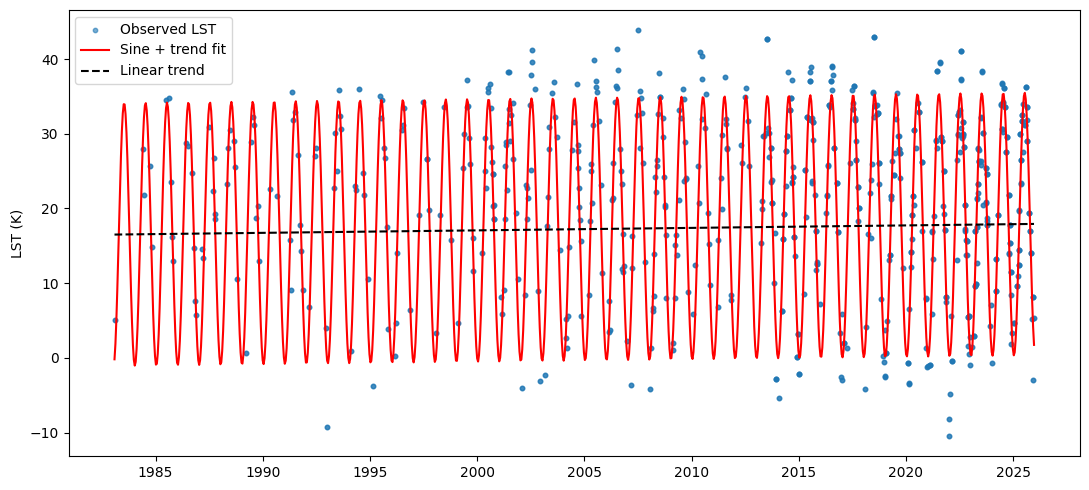

Seasonal amplitude: 17.57 K
Warming rate: 0.033 K/year (0.33 K/decade)
Phase: -1.25 rad
Baseline: 16.51 K


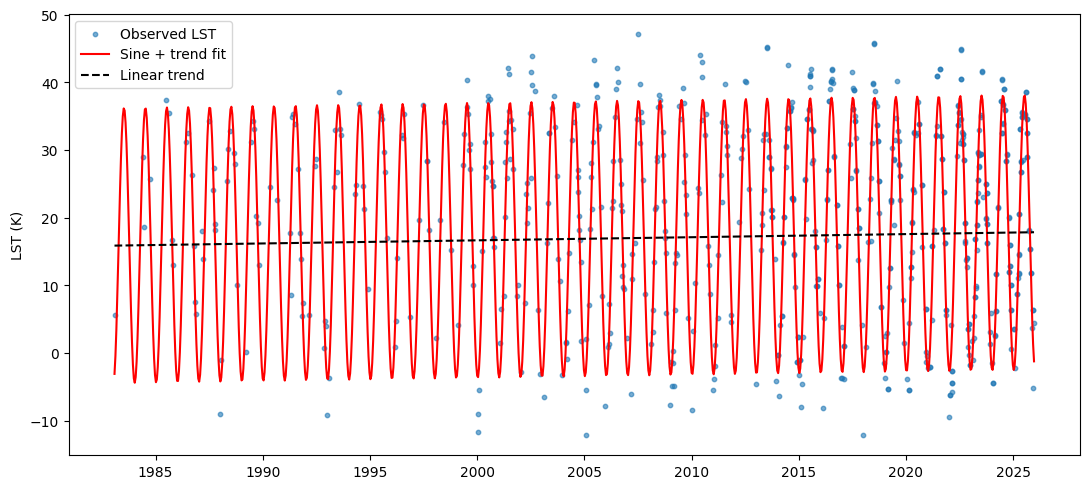

Seasonal amplitude: 20.31 K
Warming rate: 0.046 K/year (0.46 K/decade)
Phase: -1.20 rad
Baseline: 15.87 K


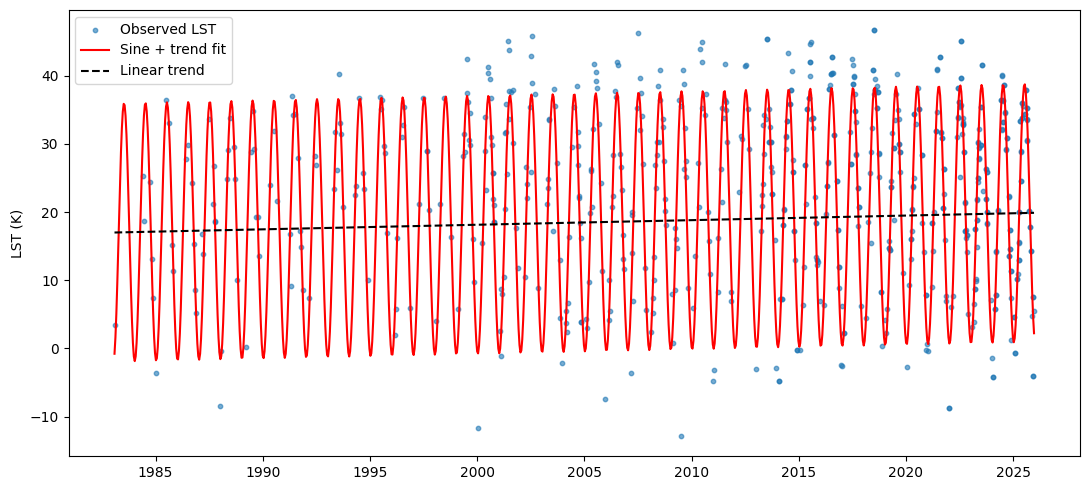

Seasonal amplitude: 18.93 K
Warming rate: 0.067 K/year (0.67 K/decade)
Phase: -1.22 rad
Baseline: 17.01 K


In [115]:
fit_graph_print(dates, y, t)
fit_graph_print(dates2, y2, t2)
fit_graph_print(dates3, y3, t3)
